In [1]:
# import cudf
# from cuml import RandomForestClassifier as cuRF

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer 

import numpy as np
import pandas as pd
import re
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

import seaborn as sns
import string

from IPython.display import display, HTML

In [2]:
HASHTAG_REGEXP = "#\w+"
LINK_REGEXP = r"https?://[\w./-]+"
HANDLE_REGEXP = "@\S+"
STOPWORDS = stopwords.words('english')

In [3]:
def clean_location(row, location_col='location'):
    if row[location_col] is np.nan or not row[location_col].strip().replace("\'|#|@", ""):
        return "N/A"
    ret_val = re.sub("\W+", ' ', row[location_col].lower())
    ret_val = re.sub("[\s\d]+", ' ', ret_val.strip()).strip()
    if len(ret_val) == 0:
        return "N/A"
    else:
        return ret_val

def lemmatize_sentence(text, tokenizer, lemmatizer):
    tokens_pos_tag = pos_tag(tokenizer.tokenize(text))
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    tokens_wordnet = [
        (word, tag_dict.get(pos[0], wordnet.NOUN)) for word, pos in tokens_pos_tag
    ]
    lem_tokens = [lemmatizer.lemmatize(word, pos) for word, pos in tokens_wordnet]
    return lem_tokens

In [4]:
def add_features(df, tokenizer, lemmatizer, text_col="text", keyword_col="keyword"):
    ret_df = df.copy()
    return ret_df.assign(
        keyword=lambda x: ret_df[keyword_col].fillna("N/A"),
        hashtag_in_text=ret_df[text_col].str.contains(HASHTAG_REGEXP),
        hashtags=ret_df[text_col].apply(lambda x: re.findall(HASHTAG_REGEXP, x)),
        link_in_text=ret_df[text_col].str.contains(LINK_REGEXP),
        links=ret_df[text_col].apply(lambda x: re.findall(LINK_REGEXP, x)),
        mention_in_text=ret_df[text_col].str.contains(HANDLE_REGEXP),
        mentions=ret_df[text_col].apply(lambda x: re.findall(HANDLE_REGEXP, x)),
        location=ret_df.apply(clean_location, location_col="location", axis=1),
        tokens=ret_df[text_col].apply(tokenizer.tokenize),
        lem_tokens=ret_df[text_col].apply(
            lemmatize_sentence, tokenizer=tokenizer, lemmatizer=lemmatizer
        ),
        lem_text=lambda x: x["lem_tokens"].apply(" ".join),
        word_count=lambda x: x["tokens"].apply(len),
        unique_tokens=lambda x: x["tokens"].apply(set),
        unique_word_count=lambda x: x["unique_tokens"].apply(len),
        stop_word_count=lambda x: x["tokens"].apply(
            lambda y: len([token for token in y if token in STOPWORDS])
        ),
        link_count=lambda x: x["links"].apply(len),
        hashtag_count=lambda x: x["hashtags"].apply(len),
        mention_count=lambda x: x["mentions"].apply(len),
        char_count=lambda x: x["tokens"].apply(
            lambda y: np.sum([len(token) for token in y])
        ),
        mean_word_length=lambda x: x["char_count"] / x["word_count"],
        punctuation_count=lambda x: x["tokens"].apply(
            lambda y: len([token for token in y if token in string.punctuation])
        ),
    )


def reduce_locations(df, location_col="location", id_col="id"):
    # Handle location categories that only appear a single time by replacing them with N/A
    ret_df = df.copy()

    single_location_list = (
        ret_df.groupby(location_col, as_index=False)
        .agg({id_col: "count"})
        .rename(columns={id_col: "row_count"})
        .query("row_count == 1")[location_col]
        .tolist()
    )

    return ret_df.assign(
        location=ret_df[location_col].where(
            ~ret_df[location_col].isin(single_location_list), other="N/A"
        )
    )

In [5]:
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer(reduce_len=True)

train_df = (pd.read_csv("./train.csv")
           .pipe(add_features, tokenizer=tknzr, lemmatizer=wnl)
           .pipe(reduce_locations))

### Features to Add
- word_count number of words in text
- unique_word_count number of unique words in text
- stop_word_count number of stop words in text
- url_count number of urls in text
- mean_word_length average character count in words
- char_count number of characters in text
- punctuation_count number of punctuations in text
- hashtag_count number of hashtags (#) in text
- mention_count number of mentions (@) in text

In [7]:
# Plot the distributions for the new features
features_to_plot = ['word_count', 'unique_word_count', 'stop_word_count', 'link_count', 'hashtag_count',
                    'mention_count', 'char_count', 'mean_word_length', 'punctuation_count']

In [9]:
#g = sns.FacetGrid(data=temp_df, row='variable', hue='target', aspect=2, sharex=False, sharey=False)
#g.map(sns.distplot, 'value', label=['1', '0'] )

/home/sjustice/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/sjustice/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


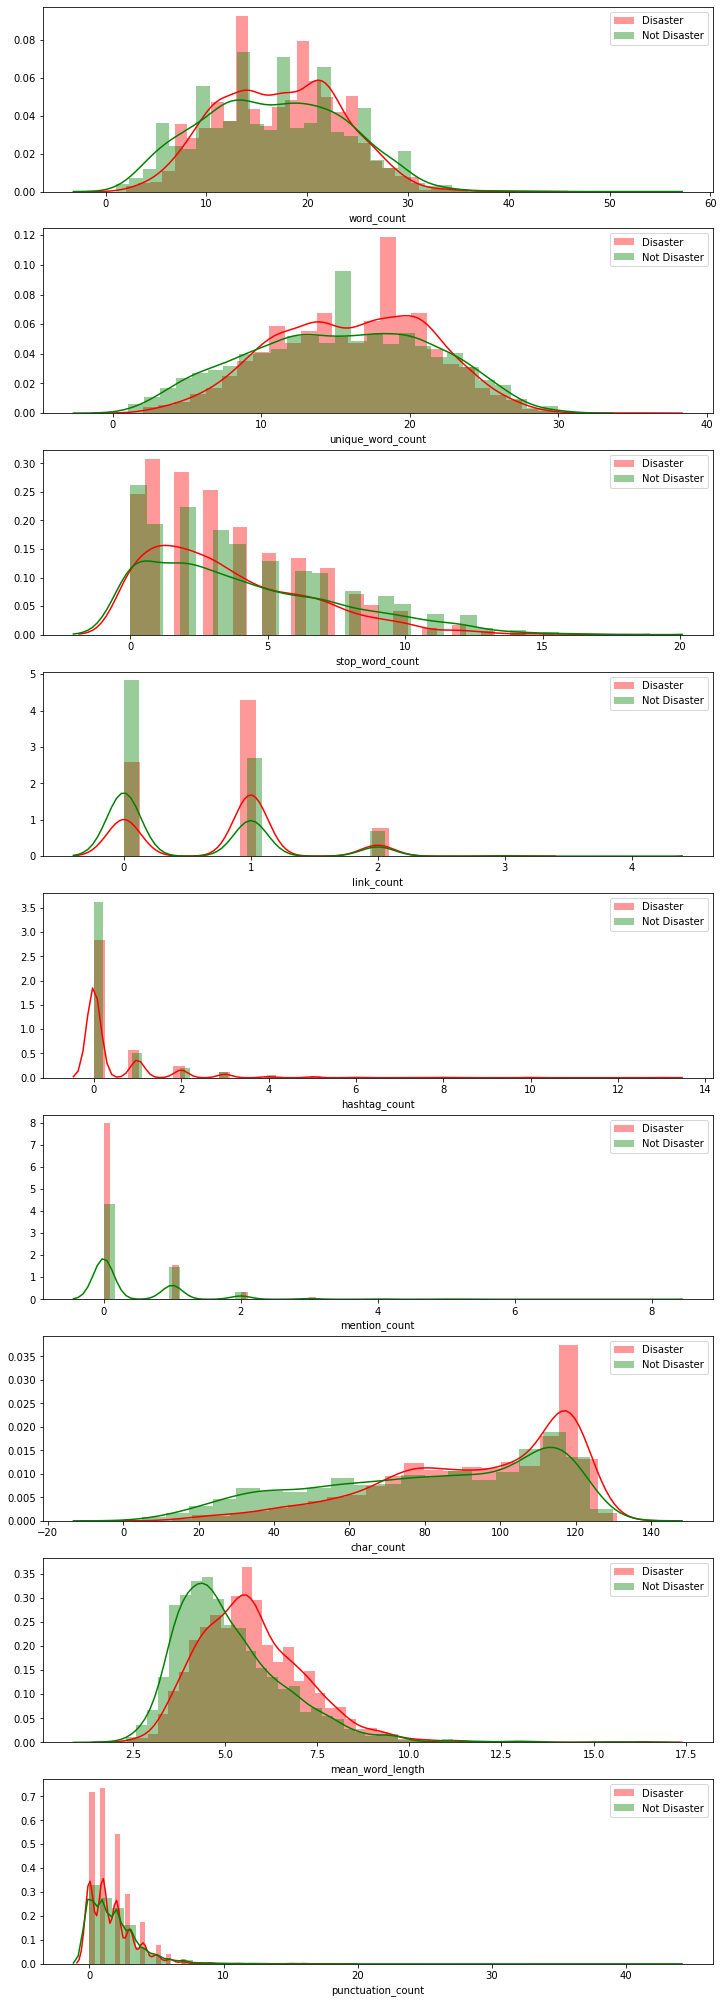

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=len(features_to_plot), figsize=(12, 4*len(features_to_plot)))
disaster_series = train_df['target'] == 1

for feature, ax in zip(features_to_plot, axes.ravel()):
    sns.distplot(train_df.loc[disaster_series][feature], ax=ax, label='Disaster', color='red')
    sns.distplot(train_df.loc[~disaster_series][feature], ax=ax, label='Not Disaster', color='green')
    ax.legend()

In [13]:
from nltk.util import ngrams

In [127]:
from collections import Counter

In [18]:
import nltk
nltk.download('punkt', force=True)

[nltk_data] Downloading package punkt to /home/sjustice/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
from itertools import chain
import string

In [57]:
punct_list = list(string.punctuation)

In [76]:
disaster_text = ' '.join([token for token in train_df.query('target == 1')['text'].str.lower().tolist()
                          if token not in STOPWORDS and token not in punct_list] )

### Clean up text
- Remove html tags
    - Use HTMLParser
- Expand contractions (maybe skip this one???)
     - Consider using POS tagger
     - Install Stanford tagger
- Convert text to unicode
    - Maybe filter out the non ASCII characters?
    
    

In [106]:
import os

In [97]:
from html.parser import HTMLParser
html_parser = HTMLParser()

In [94]:
html_tag_list = train_df.loc[train_df['text'].str.contains("&lt")]['id'].tolist()
html_tag_slice = html_tag_list[:10]

In [98]:
train_df.query('id in @html_tag_slice')['text'].apply(lambda x: html_parser.unescape(x))

/home/sjustice/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  """Entry point for launching an IPython kernel.


195     when you don't know which way an ambulance is ...
515     @MageAvexis < things. And what if we get attac...
656     @audacityjamesta Don't be like that babes <3 y...
1634    Great British <b>Bake</b> Off's back and Dorre...
1837    He was only .4 of a second faster than me and ...
2023    @BlizzHeroes @DustinBrowder DAD. I won't chase...
2680    #hiphop #news #indie Apollo Brown ÛÒ ÛÏDeton...
3271    'Tube strike live: Latest travel updates as Lo...
4099    UNR continues Severe Thunderstorm Warning [win...
4259    Arnhem Weather - <p>An unrelenting and dangero...
Name: text, dtype: object

In [105]:
train_df.iloc[2680]['text']

"#hiphop #news #indie Apollo Brown \x89ÛÒ \x89ÛÏDetonate\x89Û\x9d Ft. M.O.P. - &lt;a href='http://t.co/WnowfVCbMs... http://t.co/JxWOjxqndC"

In [104]:
train_df.iloc[2680]['text'].encode('utf-8')

b"#hiphop #news #indie Apollo Brown \xc2\x89\xc3\x9b\xc3\x92 \xc2\x89\xc3\x9b\xc3\x8fDetonate\xc2\x89\xc3\x9b\xc2\x9d Ft. M.O.P. - &lt;a href='http://t.co/WnowfVCbMs... http://t.co/JxWOjxqndC"

In [74]:
nondisaster_text = ' '.join(train_df.query('target == 0')['text'].tolist())

In [85]:
pd.Series(ngrams([token for token in tknzr.tokenize(disaster_text)
                  if token not in STOPWORDS and token not in punct_list], 2)).value_counts().head()

(, û_)                   171
(suicide, bomber)          59
(northern, california)     41
(, û)                     41
(, ûªs)                   39
dtype: int64

In [33]:
pd.Series(ngrams(word_tokenize(' '.join([token for token in train_df['text'].tolist() if token not in STOPWORDS)), 2)).value_counts()

(http, :)             4306
(?, ?)                1894
(..., http)            587
(https, :)             409
(amp, ;)               344
                      ... 
(Lot, of)                1
(injury, even)           1
(smokes, .)              1
(OliviaMiles01, @)       1
(deai, #)                1
Length: 87670, dtype: int64

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sjustice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# from nltk.tag import StanfordNERTagger, StanfordPOSTagger

- Function to take the sentence and output the lemmatized list
    - Input is text
    - Next tokenize and get pos_tag
    - Use the pos_tage with token as input to the lemmatizer
    

In [8]:
from nltk.parse import CoreNLPParser

In [11]:
parser = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

In [18]:
test_text = train_df.sample()['text'].unique().item()

In [19]:
test_text

"You can't watch 'Home Alone 2' without telling your kids \n'she used to be on Casualty'. \n#Homealone2 #film4"

In [56]:
test_sentences = train_df.query("text.str.contains('can\\\'t')")['text']

In [62]:
replace_contractions(test_sentences.iloc[0])

'No way...I cannot eat that shit'

In [47]:
import json

In [54]:
with open("./contractions.json", 'r') as f:
    CONTRACTIONS_DICT = json.load(f)

In [61]:
def replace_contractions(text):
    for pattern, sub in CONTRACTIONS_DICT.items():
        if pattern in text:
            text = re.sub(pattern, sub, text)
    return text

- Convert text to ASCII and ignore errors
- Use htmlParse to remove tags
- Remove urls and mentions
- Replace contractions
- Replace CamelCase

In [78]:
train_df.loc[train_df['text'].str.contains("(?<!@)(?:[A-Z])(?:[a-z]+)(?:[A-Z]\w+)")].iloc[2]['text']

'#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'

In [79]:
def remove_urls(text):
    if "http:" in text:
        text = re.sub("http[:\/.\w]+", "", text)
    return text

In [147]:
[cur_string.encode('ascii', errors='ignore') 
 for cur_string in (train_df.loc[train_df['text']
                                 .str.contains("(?<!@)(?:[A-Z])(?:[a-z]+)(?:[A-Z]\w+)")]
                    ['text'].sample(10).tolist())]

[b"y'all read 12000 Nigerian refugees repatriated from Cameroon http://t.co/aVwE1LBvhn",
 b"#NowPlaying at #orchardalley in #LES of #nyc 'bioterror- manufactured fear and state repression' @abcnorio #gardens http://t.co/Ba2rRXUgsG",
 b'The Municipal Emergency Plan is now in effect. Stay safe everyone! #abstorm #yyc http://t.co/14CIcptKNa',
 b'[#Latestnews] Police officer wounded suspect dead after exchanging shots: RICHMOND Va. (AP)  A Richmond pol... http://t.co/ia1HnGnHVB',
 b'Traffic Collision - No Injury: I5 S at I5 S 43rd Ave offramp South Sac http://t.co/cT9ejXoLpu',
 b"@lordRsBiscuits That's always good for a pretty explosion.",
 b'#Christians United for #Israel (#CUFI): Jews should convert soon or die by armageddon https://t.co/4aRWwRZPsr #US http://t.co/mkJQ9yfMP8',
 b'U.S. Forest Service says spending more than half of budget on fires http://t.co/1hLVrKwgIP',
 b'Do you feel engulfed with low self-image? Take the quiz: http://t.co/ykVsttvDWo http://t.co/IFQQpUr99X',
 b'Photo: 

In [142]:
print("Reddit Will Now Quarantine OffensiveåÊContent".encode('ascii', errors='ignore'))

b'Reddit Will Now Quarantine OffensiveContent'


In [143]:
print('China\x89Ûªs stock market crash this summer has sparked interest from bargain hunters'
      'and bulls betting on a rebound. D\x89Û_ http://t.co/1yggZziZ9o'.encode('ascii', errors='ignore'))

b'Chinas stock market crash this summer has sparked interest from bargain huntersand bulls betting on a rebound. D_ http://t.co/1yggZziZ9o'


In [106]:
re.search("([A-Z][a-z]+)([A-Z][a-z]+)", test_string).group(0)

'RockyFire'

In [130]:
def replaceCamelCase(text):
    print(text)
    match = re.search("(#?[A-Z][a-z]+)([A-Z][a-z]+)", text)
    if match and match.group(0) != 'YouTube':
        sub_text = ' '.join(re.sub('#?([A-Z][a-z]+)', r' \1', re.sub('#?([A-Z]+)', r' \1', match.group(0))).split())
        # Remove hashtags from CamelCase instances
        if '#' in sub_text:
            sub_text = sub_text.replace('#', '')
        text = re.sub(match.group(0), sub_text, text)
    return text

In [131]:
replaceCamelCase("I saw on YouTube")

I saw on YouTube


'I saw on YouTube'

In [65]:
train_df.iloc[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [46]:
parser.tag_sents(parser.tokenize_sents(test_sentences.tolist()))

[[('There', 'EX'),
  ("'s", 'VBZ'),
  ('an', 'DT'),
  ('emergency', 'NN'),
  ('evacuation', 'NN'),
  ('happening', 'VBG'),
  ('now', 'RB'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('building', 'NN'),
  ('across', 'IN'),
  ('the', 'DT'),
  ('street', 'NN')],
 [('What', 'WP'), ("'s", 'VBZ'), ('up', 'JJ'), ('man', 'NN'), ('?', '.')],
 [('First', 'JJ'),
  ('night', 'NN'),
  ('with', 'IN'),
  ('retainers', 'NNS'),
  ('in', 'IN'),
  ('.', '.'),
  ('It', 'PRP'),
  ("'s", 'VBZ'),
  ('quite', 'RB'),
  ('weird', 'JJ'),
  ('.', '.'),
  ('Better', 'RBR'),
  ('get', 'VB'),
  ('used', 'VBN'),
  ('to', 'IN'),
  ('it', 'PRP'),
  (';', ':'),
  ('I', 'PRP'),
  ('have', 'VBP'),
  ('to', 'TO'),
  ('wear', 'VB'),
  ('them', 'PRP'),
  ('every', 'DT'),
  ('single', 'JJ'),
  ('night', 'NN'),
  ('for', 'IN'),
  ('the', 'DT'),
  ('next', 'JJ'),
  ('year', 'NN'),
  ('at', 'IN'),
  ('least', 'JJS'),
  ('.', '.')],
 [("'", '``'),
  ('I', 'PRP'),
  ('ca', 'MD'),
  ("n't", 'RB'),
  ('have', 'VB'),
  ('kids', 'NNS'),
  ('

In [31]:
"Paul's driving".split(' ')

["Paul's", 'driving']

In [32]:
parser.tag("He's driving".split(' '))

[('He', 'PRP'), ("'s", 'VBZ'), ('driving', 'VBG')]

In [30]:
parser.tag("Paul's car is pretty".split(' '))

[('Paul', 'NNP'),
 ("'s", 'POS'),
 ('car', 'NN'),
 ('is', 'VBZ'),
 ('pretty', 'RB')]

In [6]:
# from nltk import download
# download('averaged_perceptron_tagger')
# download('wordnet')

- There are a lot of location categories that only appear once
    - 2818 locations only appear once
    - Some of them are in lowercase
    - Convert the location to lower and remove punctuation
    - Maybe remove those or ones with less than 5 occurances and replace them with None?

- Replace all locations that appear only once with N/A

- Perform a train/test split and then use the stemmer and the vectorizer on the train set
- Need to be able to align the features from the train set so that they are the same in the test set
    - Only include the ones in the train set - No new features in the test set
    
- Perform lematization on the text. 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[
        [
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]
    ],
    train_df["target"],
    random_state=42,
    stratify=train_df["target"],
    test_size=0.2,
)

In [13]:
cat_feature_list =['keyword', 'location', 'hash_in_text', 'handle_in_text']

# Use a column transformer instead of the FeatureUnion since it accomplishes the same thing without
# needing a custom class

pipe = Pipeline(
    [
        (
            "text_transform",
            ColumnTransformer([("ohe", OneHotEncoder(handle_unknown='ignore'), cat_feature_list),
                                  ("tfidf", TfidfVectorizer(), 'lem_text')]),
        ),
#         ("cudf_convert", CudfConversion()),
        ("rf", RandomForestClassifier(random_state=42, n_jobs=1) )
    ]
)

- Things to check for in the text
    - @s - tweets directed at other users
    - #s - hashtags
    - retweets - urls
    - Name entity
    - Allcaps words??? - Remove them or keep them?
    - Remove the ats, hashtags, and urls from the text before putting it through a tfidf vectorizer
    - A lot of repeated location categories - Need to handle instances like 'Chicago, IL' and 'Chicago,IL'

In [14]:
param_grid = {
    "rf__n_estimators": range(3000, 10001, 500),
    "rf__max_depth": [None, 10, 20, 40],
    "rf__min_samples_split": [2, 4, 6],
    "rf__min_samples_leaf": [1, 2, 3],
    "rf__max_features": ["auto", "log2", 20, 40, 60, 100],
    "text_transform__tfidf__ngram_range": [(1,1), (1,2), (1,3), (2,3)],
    "text_transform__tfidf__max_df": [0.9, 0.95, 0.99],
    "text_transform__tfidf__min_df": [2, 5, 10]
}

In [17]:
rcv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=30,
                         scoring='f1', cv=3, random_state=42, verbose=2, n_jobs=7)

In [18]:
rcv.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done  90 out of  90 | elapsed: 25.8min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('text_transform',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['keyword',
                                                                                'location',
                                                                                'hash_in_text',
                                                                                'handle_in_text']),
                                                                              ('tfidf',
                                                                               TfidfVectorizer(),
                                                                               'lem_text')])),
                                             (

In [20]:
rcv.best_params_

{'text_transform__tfidf__ngram_range': (1, 1),
 'text_transform__tfidf__min_df': 10,
 'text_transform__tfidf__max_df': 0.99,
 'rf__n_estimators': 7000,
 'rf__min_samples_split': 4,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': None}

In [81]:
best_pipe = rcv.best_estimator_

In [80]:
rcv.score(X_test, y_test)

0.7210300429184551

In [79]:
import pickle

with open('rf_model_with_pipe.pkl', 'wb') as f:
    pickle.dump(rcv, f)

# # and later you can load it
# with open('filename.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [79]:
test_df = (pd.read_csv("./test.csv")
           .pipe(add_features, tokenizer=tknzr, lemmatizer=wnl)
           .pipe(reduce_locations))

In [88]:
X_train.head()

,keyword,location,text,hashtag_in_text,link_in_text,handle_in_text,lem_text
6234,snowstorm,south usa,Sassy city girl country hunk stranded in Smoky...,True,True,False,Sassy city girl country hunk strand in Smoky M...
326,armageddon,worldwide,God's Kingdom (Heavenly Gov't) will rule over ...,False,True,False,God's Kingdom ( Heavenly Gov't ) will rule ove...
997,body%20bagging,N/A,Mopheme and Bigstar Johnson are a problem in t...,True,False,False,Mopheme and Bigstar Johnson be a problem in th...
7269,whirlwind,N/A,@VixMeldrew sounds like a whirlwind life!,False,False,True,@VixMeldrew sound like a whirlwind life !
2189,debris,nigeria,Malaysia confirms plane debris washed up on Re...,False,True,False,Malaysia confirm plane debris wash up on Reuni...


In [89]:
test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].head()

,keyword,location,text,hashtag_in_text,link_in_text,handle_in_text,lem_text
0,N/A,N/A,Just happened a terrible car crash,False,False,False,Just happen a terrible car crash
1,N/A,N/A,"Heard about #earthquake is different cities, s...",True,False,False,"Heard about #earthquake be different city , st..."
2,N/A,N/A,"there is a forest fire at spot pond, geese are...",False,False,False,"there be a forest fire at spot pond , geese be..."
3,N/A,N/A,Apocalypse lighting. #Spokane #wildfires,True,False,False,Apocalypse light . #Spokane #wildfires
4,N/A,N/A,Typhoon Soudelor kills 28 in China and Taiwan,False,False,False,Typhoon Soudelor kill 28 in China and Taiwan


In [90]:
best_pipe.predict(test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].rename(columns={"hashtag_in_text": "hash_in_text"}))

array([0, 1, 1, ..., 1, 1, 0])

In [91]:
test_df = test_df.assign(target=best_pipe.predict(test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].rename(columns={"hashtag_in_text": "hash_in_text"})))

In [94]:
test_df[['id', 'target']].to_csv("submission_0706.csv", index=False)